# Diffusion

## Loading the dataset

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import pprint
import math

def show_images(dataset, num_samples=20, cols=4):
    """Plot some images from a given dataset"""
    plt.figure(figsize=(15, 15))
    for i, img in enumerate(dataset):
        if i == num_samples:
            break
        plt.subplot(num_samples // cols + 1, cols, i + 1)
        plt.imshow(img[0])

In [2]:
def min_dimensions(dataset):
    min_x = float("inf")
    min_y = float("inf")
    for i, img in enumerate(dataset):
        x, y = img[0].size
        min_x = min(min_x, x)
        min_y = min(min_y, y)
    return min_x, min_y

(500, 500)

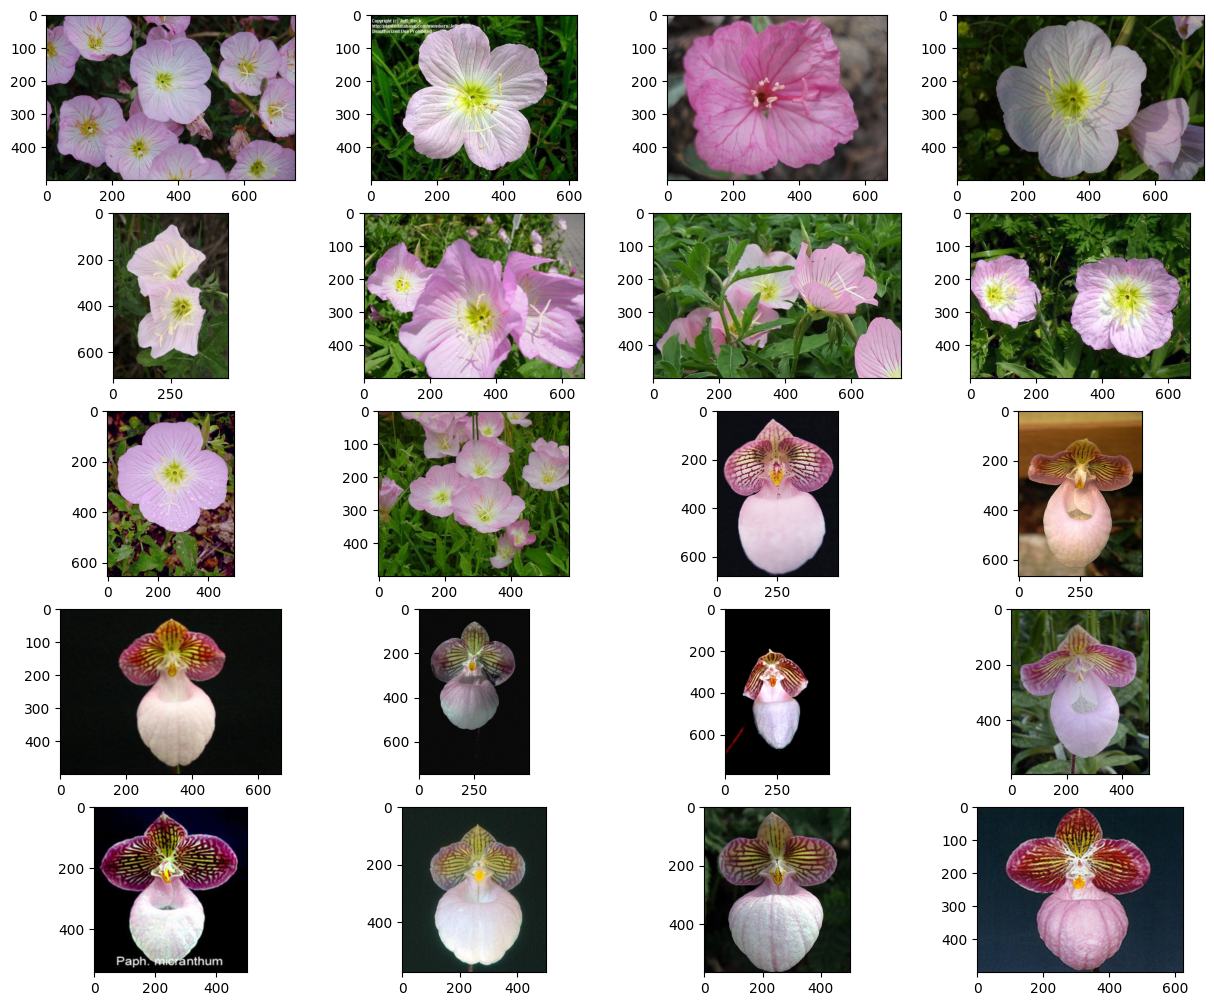

In [3]:
data = torchvision.datasets.Flowers102(root=".", download=True)
show_images(data)
min_dimensions(data)

## Forward process

In [4]:
import torch.nn.functional as F

# Pre-calculate alpha values

def beta_scheduler(timesteps, schedule_name = "cosine", start=0.0001, end=0.02, s=0.008, max_beta=0.999):
    if schedule_name == "linear":
        return torch.linspace(start=start, end=end, steps=timesteps)
    elif schedule_name == "cosine":
        s = 0.008 # as defined in paper
        max_beta = 0.999 # as per paper, to prevent singularities
        alphas_cumprod_func = lambda t: math.cos((t + s) / (1+s) * math.pi / 2)
        betas = []
        for i in range(timesteps):
            t1 = i / timesteps
            t2 = (i + 1) / timesteps
            beta = min(1 - alphas_cumprod_func(t2) / alphas_cumprod_func(t1), max_beta)
            betas.append(beta)
        return torch.FloatTensor(betas)

def pre_compute_values(betas: torch.Tensor) -> dict[str, torch.tensor]:
    values = {}
    values["betas"] = betas
    values["alphas"] = 1. - values["betas"]
    values["alphas_cumprod"] = torch.cumprod(values["alphas"], axis=0)
    values["alphas_cumprod_prev"] = F.pad(values["alphas_cumprod"][:-1], (1, 0), value=1.0)
    values["sqrt_recip_alphas"] = torch.sqrt(1.0 / values["alphas"])
    values["sqrt_alphas_cumprod"] = torch.sqrt(values["alphas_cumprod"])
    values["sqrt_one_minus_alphas_cumprod"] = torch.sqrt(1. - values["alphas_cumprod"])
    values["posterior_variance"] = betas * (1. - values["alphas_cumprod_prev"]) / (1. - values["alphas_cumprod"])
    return values


def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, values, device="cpu"):
    sqrt_alphas_cumprod = values["sqrt_alphas_cumprod"]
    sqrt_one_minus_alphas_cumprod = values["sqrt_one_minus_alphas_cumprod"]

    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)
    mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
    variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)
    return mean + variance, noise.to(device)


In [12]:
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 64
BATCH_SIZE = 32

def load_transformed_dataset():
    data_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)), 
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(), 
        transforms.Lambda(lambda t: (t * 2) - 1)
    ])


    train = torchvision.datasets.Flowers102(root=".", download=True, transform=data_transforms, split="train")
    test = torchvision.datasets.Flowers102(root=".", download=True, transform=data_transforms, split="test")

    return torch.utils.data.ConcatDataset([train, test])

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2), 
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), 
        transforms.Lambda(lambda t: t * 255), 
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage()
    ])

    if len(image.shape) == 4: # we have a batch of images
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image.detach().cpu()))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [13]:
# Define terms for beta
T = 50
betas = beta_scheduler(timesteps=T, schedule_name="cosine")
pre_comp_values = pre_compute_values(betas)
# pprint.pprint(list(pre_comp_values.keys()))

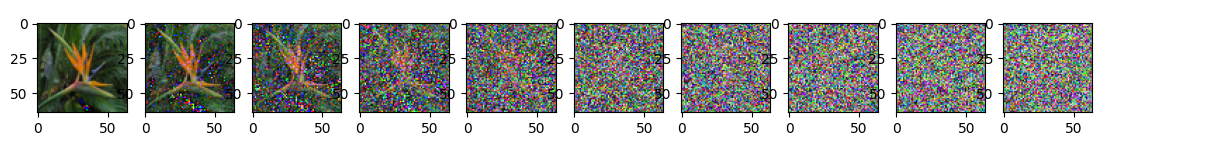

In [14]:
image = next(iter(dataloader))[0]

num_images = 10
plt.figure(figsize=(15, 15 / num_images))
plt.axis("off")
stepsize = T // num_images

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, (idx // stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t, values=pre_comp_values)
    show_tensor_image(img)

## Neural network (U-Net)

In [15]:
import torch.nn as nn
import math

class Block(nn.Module):

    def __init__(self, in_ch, out_ch, time_emb_dim, up=False) -> None:
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, kernel_size=3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, kernel_size=4, stride=2, padding=1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        # first conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # time embedding
        time_emb = self.relu(self.time_mlp(t))
        # extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # add time emb
        h = h + time_emb
        # second conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # downsample or upsample
        return self.transform(h)
    

class SinusoidalPositionEmbeddings(nn.Module):

    def __init__(self, dim) -> None:
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10_000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class SimpleUNet(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        image_channels = 3
        down_channels = [64, 128, 256, 512, 1024]
        up_channels = down_channels[::-1]
        out_dim = 3
        time_emb_dim = 32

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim), 
            nn.Linear(time_emb_dim, time_emb_dim), 
            nn.ReLU()
        )

        # initial
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], kernel_size=3, padding=1)

        # downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], time_emb_dim) for i in range(len(down_channels) - 1)])

        # upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True) for i in range(len(up_channels) - 1)])

        self.output = nn.Conv2d(up_channels[-1], out_dim, kernel_size=1)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        residual_inputs = []

        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()

            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)

        return self.output(x)
    

model = SimpleUNet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model


Num params:  62438883


SimpleUNet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

## The loss function (ELBo)

In [16]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, values=pre_comp_values, device=device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

## Sampling

In [17]:
@torch.no_grad
def sample_timestep(x, t, values):
    betas = values["betas"]
    sqrt_one_minus_alphas_cumprod = values["sqrt_one_minus_alphas_cumprod"]
    sqrt_recip_alphas = values["sqrt_recip_alphas"]
    posterior_variance = values["posterior_variance"]


    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t==0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise
    
@torch.no_grad
def sample_plot_image(values):
    img = torch.randn((1, 3, IMG_SIZE, IMG_SIZE), device=device)
    num_images = 10
    plt.figure(figsize=(15, 15 / num_images))
    plt.axis("off")
    stepsize = T // num_images

    for i in range(T-1, -1, -1):
        t = torch.full((1, ), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t, values)
        img = torch.clamp(img, -1.0, 1.0)
        if i %  stepsize == 0:
            plt.subplot(1, num_images, i // stepsize + 1)
            show_tensor_image(img.detach().cpu())
    plt.show()
    return img

@torch.no_grad
def sample_image(values):
    img = torch.randn((1, 3, IMG_SIZE, IMG_SIZE), device=device)

    for i in range(T-1, -1, -1):
        t = torch.full((1, ), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t, values)
        img = torch.clamp(img, -1.0, 1.0)
    return img


## Training

Epoch 5 | Loss: 0.1859990805387497 


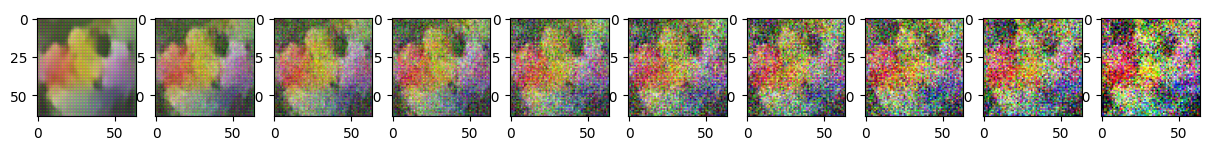

Epoch 10 | Loss: 0.1974974125623703 


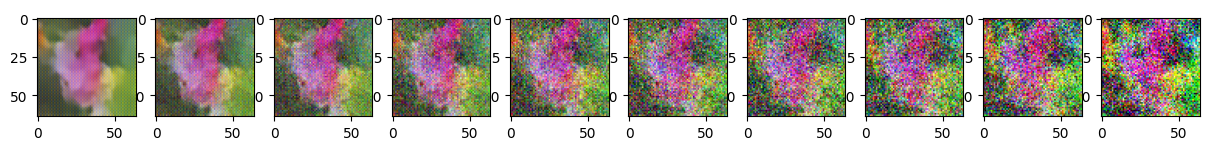

Epoch 15 | Loss: 0.18470308184623718 


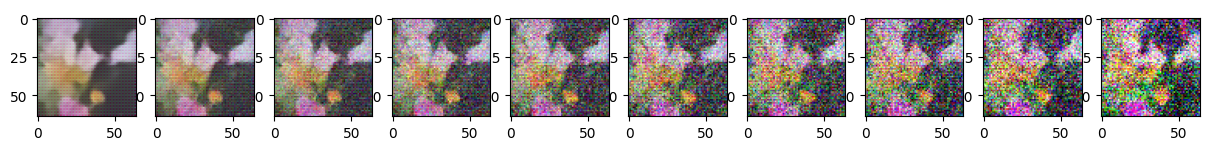

Epoch 20 | Loss: 0.2164429873228073 


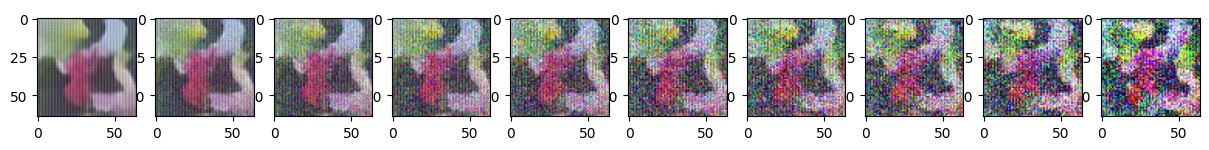

Epoch 25 | Loss: 0.17511241137981415 


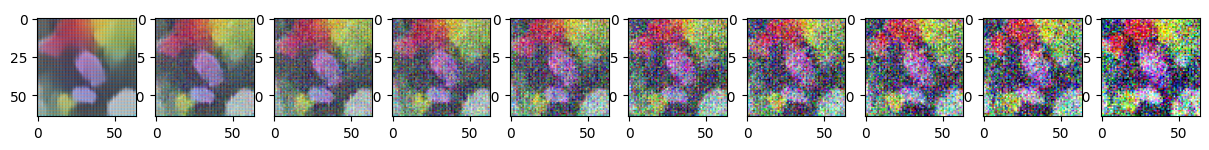

Epoch 30 | Loss: 0.19958367943763733 


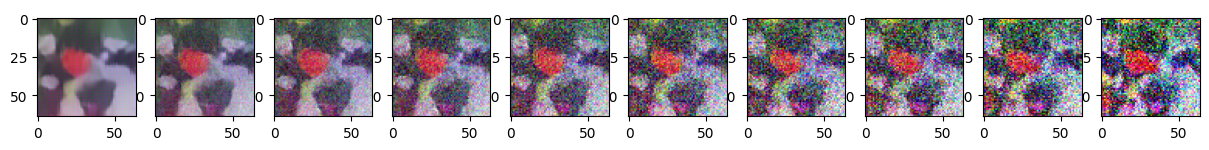

Epoch 35 | Loss: 0.20179906487464905 


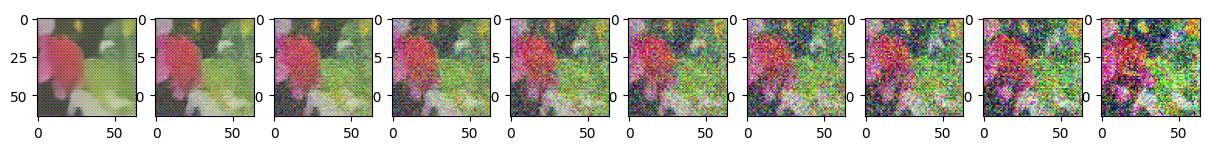

Epoch 40 | Loss: 0.15818332135677338 


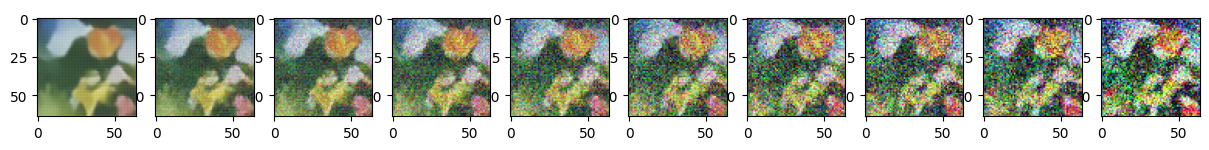

Epoch 45 | Loss: 0.18084661662578583 


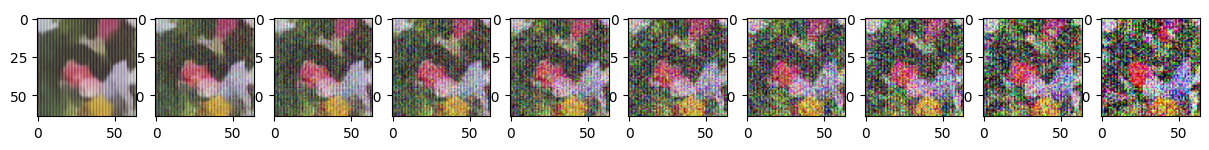

Epoch 50 | Loss: 0.19537334144115448 


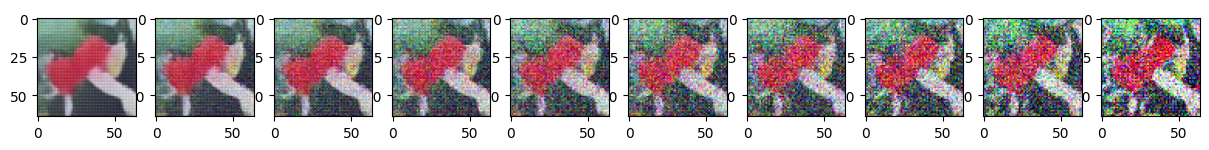

Epoch 55 | Loss: 0.20628134906291962 


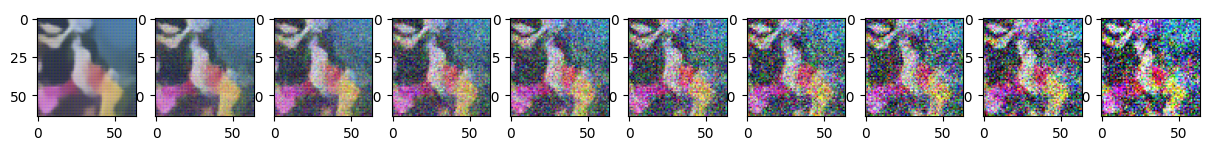

Epoch 60 | Loss: 0.18636402487754822 


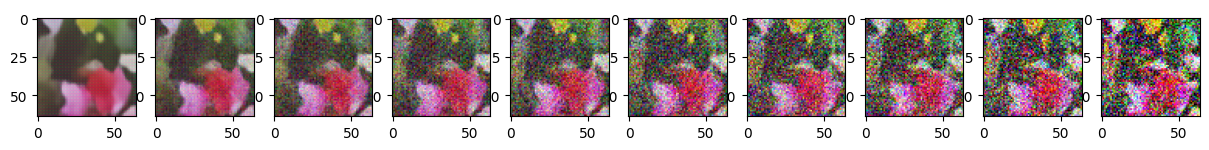

In [18]:
from torch.optim import Adam

device = "mps" if torch.backends.mps.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
begin_epoch = 0
end_epoch = 400

for epoch in range(begin_epoch+1, end_epoch+1):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE, ), device=device).long()
        loss = get_loss(model, batch[0], t)
        loss.backward()
        optimizer.step()

        if epoch % 5 == 0 and step == 0:
            print(f"Epoch {epoch} | Loss: {loss.item()} ")
            sample_plot_image(values=pre_comp_values)
    if epoch % 100 == 0:
        torch.save(model.state_dict(), f"./flower/model_{epoch}_V3")

## Loading model

In [ ]:
LOAD_EPOCH = 400
VERSION = "V2"
DIR = "flower"

PATH = f"{DIR}/model_{LOAD_EPOCH}_{VERSION}"

model = SimpleUNet()
model.load_state_dict(torch.load(PATH))
model.to(device);

In [ ]:
def generate_n_images(n: int) -> None:
    """Generates up to n images in a grid. May take several minutes
    for large values of n.

    Args:
        n (int): the number of images to be generated.
    """
    num_images = n
    n_columns = 10
    n_rows = num_images // (n_columns+1) + 1
    plt.figure(figsize=(1.5 * n_columns, 1.5 * n_rows))
    plt.axis("off")

    for i in range(num_images):
        plt.subplot(n_rows, n_columns, i + 1)
        img = sample_image(values=pre_comp_values)
        show_tensor_image(img)

In [ ]:
generate_n_images(10)

In [ ]:
generate_n_images(11)